# Definición del problema:

El proposito del proyecto es predecir qué pasajeros fueron transportados por la anomalía utilizando registros recuperados del sistema informático dañado de la nave espacial.

# Estadística descriptiva:

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [63]:
train = pd.read_csv('https://raw.githubusercontent.com/WolfgangBreytmann/MAT281_rep/master/CSV%20aplica/datasets_proyecto/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/WolfgangBreytmann/MAT281_rep/master/CSV%20aplica/datasets_proyecto/test.csv')

Tamaño de los datasets

In [64]:
print( train.shape)
print( test.shape)

(8693, 14)
(4277, 13)


In [65]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [66]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [67]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


# Visualizacion de los datos

Text(0.5, 0, 'Age (years)')

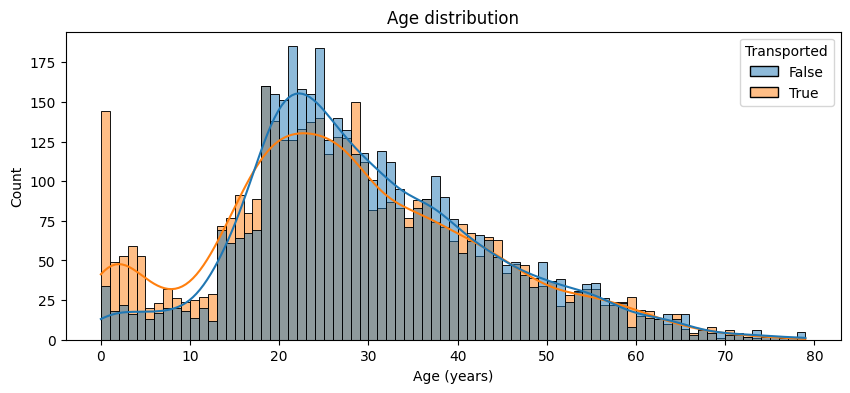

In [68]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

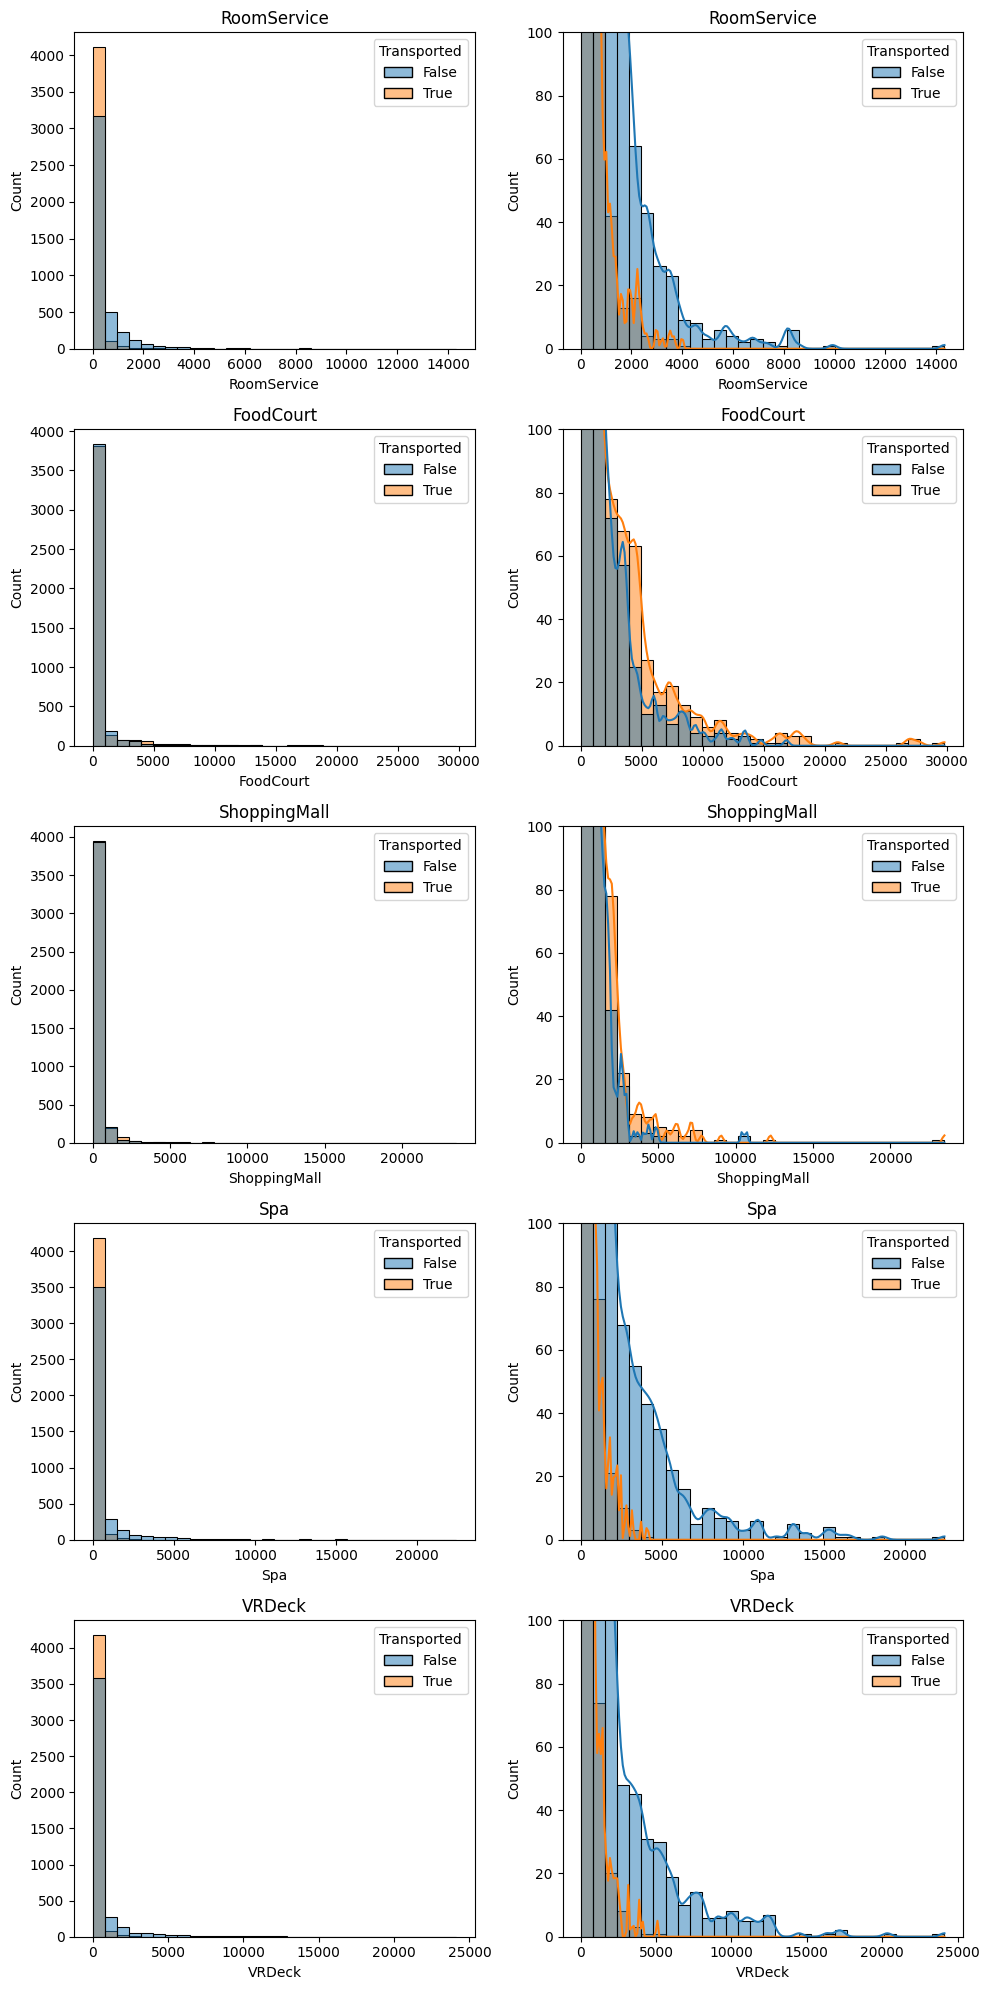

In [69]:
# Expenditure features
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)

    # Right plot (truncated)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

Podemos ver que las caracteristicas más importantes (sin considerarlas en interaccion con otras caracteristicas) son RoomService, FoodCourt y Spa.

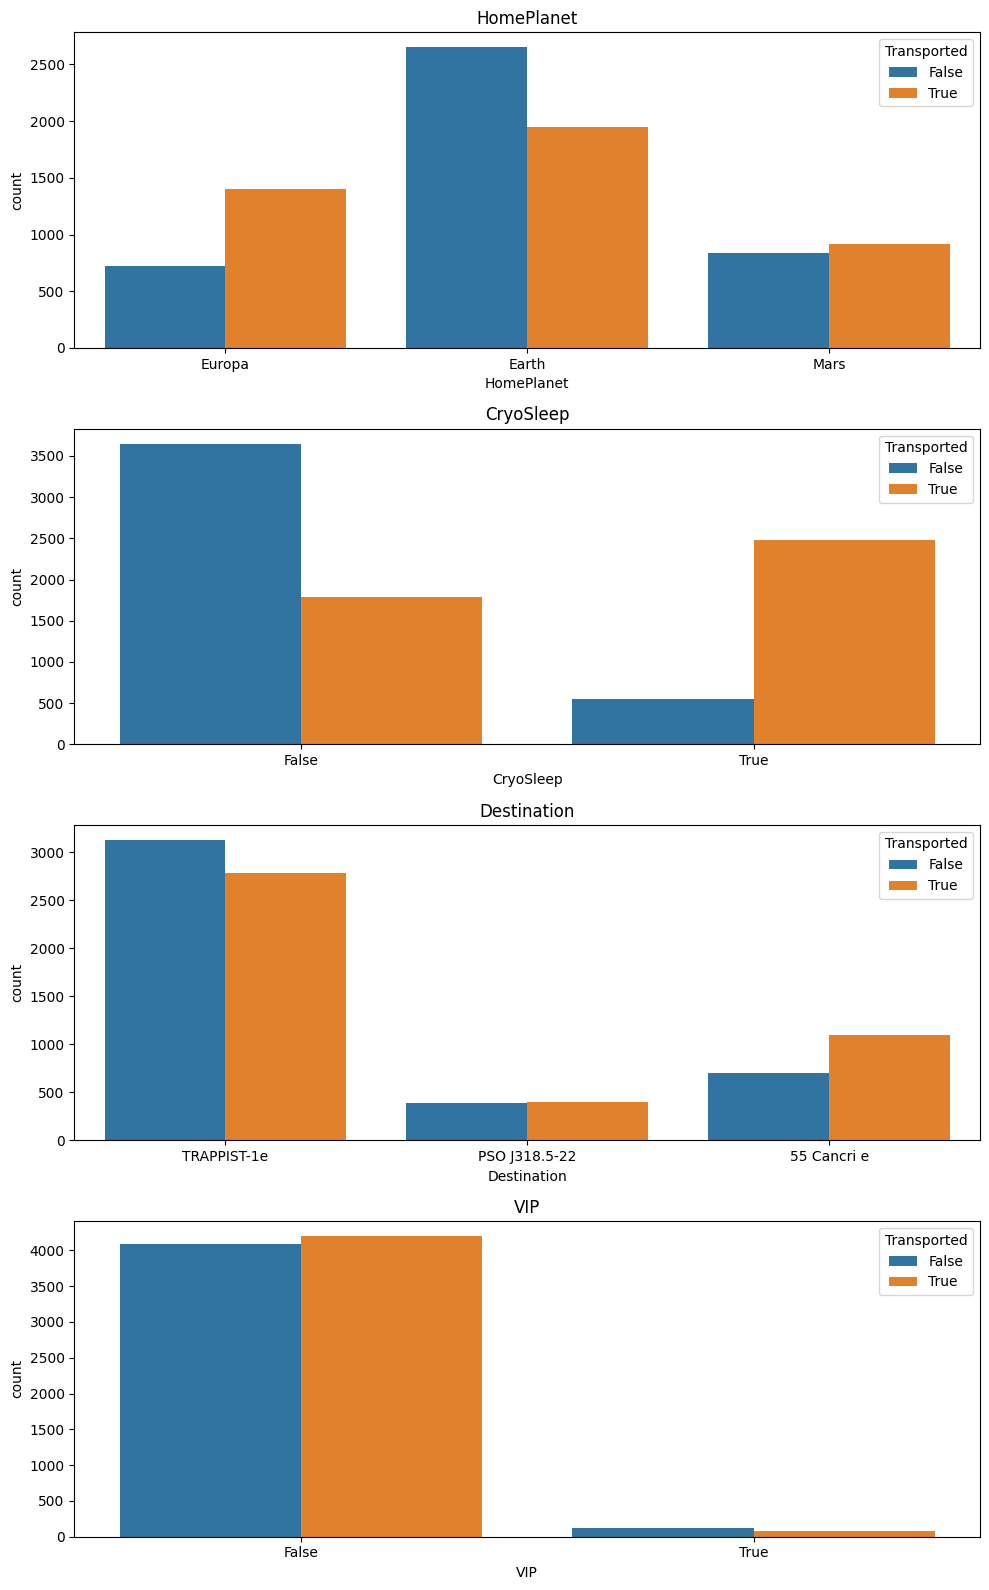

In [70]:
# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

Claramente las variables Homeplanet y CryoSleep son las más importantes

# Preprocesamiento

Los valores PassengerId, Name, a priori, no son utiles para la predicción, por lo que lo sacaremos

In [71]:
train = train.drop(['PassengerId', 'Name'], axis=1)

Nos quedaremos con las variables mas importantes según el analisis anterior

In [72]:
train.columns

Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported'],
      dtype='object')

In [73]:
train=train[['Age','HomePlanet', 'CryoSleep','RoomService', 'FoodCourt','Spa','Transported']]
train

,Age,HomePlanet,CryoSleep,RoomService,FoodCourt,Spa,Transported
0,39.0,Europa,False,0.0,0.0,0.0,False
1,24.0,Earth,False,109.0,9.0,549.0,True
2,58.0,Europa,False,43.0,3576.0,6715.0,False
3,33.0,Europa,False,0.0,1283.0,3329.0,False
4,16.0,Earth,False,303.0,70.0,565.0,True
...,...,...,...,...,...,...,...
8688,41.0,Europa,False,0.0,6819.0,1643.0,False
8689,18.0,Earth,True,0.0,0.0,0.0,False
8690,26.0,Earth,False,0.0,0.0,1.0,True
8691,32.0,Europa,False,0.0,1049.0,353.0,False


In [74]:
train = train.dropna()

In [75]:
train

,Age,HomePlanet,CryoSleep,RoomService,FoodCourt,Spa,Transported
0,39.0,Europa,False,0.0,0.0,0.0,False
1,24.0,Earth,False,109.0,9.0,549.0,True
2,58.0,Europa,False,43.0,3576.0,6715.0,False
3,33.0,Europa,False,0.0,1283.0,3329.0,False
4,16.0,Earth,False,303.0,70.0,565.0,True
...,...,...,...,...,...,...,...
8688,41.0,Europa,False,0.0,6819.0,1643.0,False
8689,18.0,Earth,True,0.0,0.0,0.0,False
8690,26.0,Earth,False,0.0,0.0,1.0,True
8691,32.0,Europa,False,0.0,1049.0,353.0,False


Se eliminaron aproximadamente 2000 datos

In [76]:
print(train['Transported'].sum())
print(7760-train['Transported'].sum())

3829
3931


Podemos observar que las clases estan balanceadas

In [77]:
train

,Age,HomePlanet,CryoSleep,RoomService,FoodCourt,Spa,Transported
0,39.0,Europa,False,0.0,0.0,0.0,False
1,24.0,Earth,False,109.0,9.0,549.0,True
2,58.0,Europa,False,43.0,3576.0,6715.0,False
3,33.0,Europa,False,0.0,1283.0,3329.0,False
4,16.0,Earth,False,303.0,70.0,565.0,True
...,...,...,...,...,...,...,...
8688,41.0,Europa,False,0.0,6819.0,1643.0,False
8689,18.0,Earth,True,0.0,0.0,0.0,False
8690,26.0,Earth,False,0.0,0.0,1.0,True
8691,32.0,Europa,False,0.0,1049.0,353.0,False


# Entrenamiento

In [78]:
y=train['Transported'].copy().astype(int)
X=train.drop('Transported', axis=1).copy()

In [79]:
X

,Age,HomePlanet,CryoSleep,RoomService,FoodCourt,Spa
0,39.0,Europa,False,0.0,0.0,0.0
1,24.0,Earth,False,109.0,9.0,549.0
2,58.0,Europa,False,43.0,3576.0,6715.0
3,33.0,Europa,False,0.0,1283.0,3329.0
4,16.0,Earth,False,303.0,70.0,565.0
...,...,...,...,...,...,...
8688,41.0,Europa,False,0.0,6819.0,1643.0
8689,18.0,Earth,True,0.0,0.0,0.0
8690,26.0,Earth,False,0.0,0.0,1.0
8691,32.0,Europa,False,0.0,1049.0,353.0


In [80]:
y

0       0
1       1
2       0
3       0
4       1
       ..
8688    0
8689    0
8690    1
8691    0
8692    1
Name: Transported, Length: 7590, dtype: int64

In [81]:
# Indentify numerical and categorical columns
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Scale numerical data to have mean=0 and variance=1
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# One-hot encode categorical data
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore',sparse=False))])

# Combine preprocessing
ct = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)],
        remainder='passthrough')

# Apply preprocessing
X = ct.fit_transform(X)


In [82]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,stratify=y,train_size=0.8,test_size=0.2,random_state=0)

In [83]:
X_train.shape

(6072, 8)

In [84]:
y_train

4787    0
2286    0
8366    1
1394    1
4063    1
       ..
7899    0
7135    1
780     1
4967    1
8033    1
Name: Transported, Length: 6072, dtype: int64

In [85]:
classifiers = {
    "LogisticRegression" : LogisticRegression(random_state=0),
    "KNN" : KNeighborsClassifier(),
    "RandomForest" : RandomForestClassifier(random_state=0),
}

LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

KNN_grid = {'n_neighbors': [3, 5, 7, 9],
            'p': [1, 2]}

RF_grid = {'n_estimators': [50, 100, 150, 200, 250, 300],
        'max_depth': [4, 6, 8, 10, 12]}

grid = {
    "LogisticRegression" : LR_grid,
    "KNN" : KNN_grid,
    "RandomForest" : RF_grid,
}

In [86]:
i=0
clf_best_params=classifiers.copy()
valid_scores=pd.DataFrame({'Classifer':classifiers.keys(), 'Validation accuracy': np.zeros(len(classifiers)), 'Training time': np.zeros(len(classifiers))})
for key, classifier in classifiers.items():
    start = time.time()
    clf = GridSearchCV(estimator=classifier, param_grid=grid[key], n_jobs=-1, cv=None)

    # Train and score
    clf.fit(X_train, y_train)
    valid_scores.iloc[i,1]=clf.score(X_valid, y_valid)

    # Save trained model
    clf_best_params[key]=clf.best_params_

    # Print iteration and training time
    stop = time.time()
    valid_scores.iloc[i,2]=np.round((stop - start)/60, 2)

    print('Model:', key)
    print('Training time (mins):', valid_scores.iloc[i,2])
    print('')
    i+=1

Model: LogisticRegression
Training time (mins): 0.07

Model: KNN
Training time (mins): 0.09

Model: RandomForest
Training time (mins): 1.58



In [87]:
svc = SVC(kernel='linear', C=1.0)
svc.fit(X_train, y_train)

SVC(kernel='linear')

In [88]:
predicciones = svc.predict(X_valid)
accuracy = accuracy_score(y_valid, predicciones)
print("Precisión en el conjunto de validación:", accuracy)

Precisión en el conjunto de validación: 0.7628458498023716


In [89]:
valid_scores

,Classifer,Validation accuracy,Training time
0,LogisticRegression,0.762846,0.07
1,KNN,0.766140,0.09
2,RandomForest,0.766798,1.58


Si bien, los valores no son tan altos hay que tener en cuenta que eliminamos una gran cantidad de datos por simplicidad del problema, ademas escogimos las caracteristicas sin considerar interacción entre ellas como lo haria PCA

In [90]:
clf_best_params

{'LogisticRegression': {'C': 0.25, 'max_iter': 50, 'penalty': 'l2'},
 'KNN': {'n_neighbors': 9, 'p': 2},
 'RandomForest': {'max_depth': 8, 'n_estimators': 150}}

In [91]:
RF =  RandomForestClassifier(max_depth = 8, n_estimators = 50 )

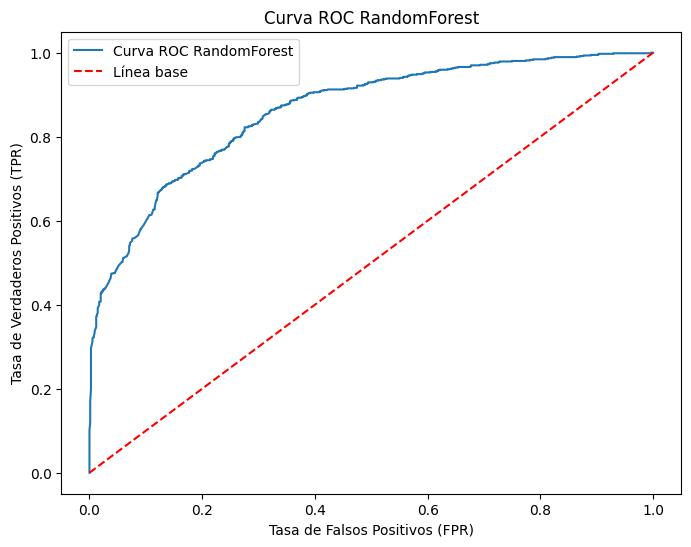

In [92]:
RF.fit(X_train, y_train)

probs_positivas_RF = RF.predict_proba(X_valid)[:, 1]  # Probabilidades de la clase positiva

# Calcular la curva ROC
fpr_rf, tpr_rf, umbrales_rf = roc_curve(y_valid, probs_positivas_RF)

# Graficar la curva ROC para RandomForest
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label='Curva ROC RandomForest')
plt.plot([0, 1], [0, 1], 'r--', label='Línea base')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC RandomForest')
plt.legend()
plt.show()

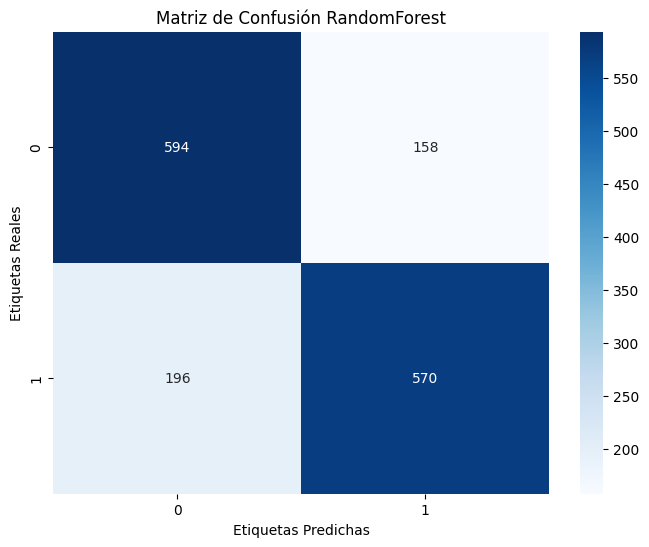

In [93]:
predicciones_rf = RF.predict(X_valid)

matriz_confusion_RF = confusion_matrix(y_valid, predicciones_rf)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion_RF, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Etiquetas Predichas')
plt.ylabel('Etiquetas Reales')
plt.title('Matriz de Confusión RandomForest')
plt.show()

In [94]:
print("Reporte de Clasificación:\n", classification_report(y_valid, predicciones_rf))

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.75      0.79      0.77       752
           1       0.78      0.74      0.76       766

    accuracy                           0.77      1518
   macro avg       0.77      0.77      0.77      1518
weighted avg       0.77      0.77      0.77      1518



# Conclusiones

El modelo anterior funciona bastante bien, pero se podria mejorar aplicando una mejor ingeneria de atributos.

Referencias: https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide